# DIY Deep Learning Trainer

In the previous chapter of our deep learning series, we introduced the foundational concepts of Multi-Layer Perceptrons (MLPs) using the MNIST dataset. We covered the entire training pipeline, including setting random seeds, downloading datasets, data normalization, data augmentation, data loading, and training/testing procedures.

In this chapter, we will advance our understanding by learning how to create a personalized Trainer class to encapsulate the training process, making it easier to reuse and adapt. Additionally, we will introduce the FashionMNIST dataset, which is slightly more complex than MNIST, providing a gentle progression in difficulty.

## Introducing FashionMNIST

FashionMNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. This dataset serves as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

## Implementing the Trainer Class

Let's start by defining a custom Trainer class in Python. This class will encapsulate all aspects of the training process, including data loading, training, validation, and testing. Here's the complete implementation:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import random
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime


class fashion_mnist_trainer:
    def __init__(self, model, lr, batch_size, epoch, train_transforms, test_transforms, seed=1234):
        self.model = model
        self.lr = lr
        self.epoch = epoch
        self.loss_f = nn.CrossEntropyLoss()

        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

        """load model, loss_fn and optimizer"""
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        if torch.cuda.is_available():
            self.loss_f = self.loss_f.cuda()
        self.scaler = GradScaler()

        """download and allocate data"""
        ROOT = '.data'
        train_valid_data = torchvision.datasets.FashionMNIST(root=ROOT, train=True, download=True, transform=train_transforms)
        test_data = torchvision.datasets.FashionMNIST(root=ROOT, train=False, download=False, transform=test_transforms)

        VALID_RATE = 0.1
        n_train = int(len(train_valid_data) * (1 - VALID_RATE))
        n_valid = len(train_valid_data) - n_train
        train_data, valid_data = torch.utils.data.random_split(train_valid_data, [n_train, n_valid])

        """load data"""
        self.train_dataloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
        self.valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
        self.test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

        """set the seed"""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    def train(self):
        valid_loss_min = np.Inf
        counter = 0
        lr = self.lr
        optimizer_f = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        for epoch in range(self.epoch):
            print('=' * 135)
            print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            print(f"Epoch {epoch + 1} / {self.epoch}")

            if counter / 10 == 1:
                counter = 0
                lr = lr * 0.5
                print(f"lr is updated to {lr}")
                optimizer_f = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

            self.model.train()
            train_bar = tqdm(self.train_dataloader, desc="[Train]", ncols=90)
            train_losses = []
            for inputs, targets in train_bar:
                if torch.cuda.is_available():
                    inputs, targets = inputs.cuda(), targets.cuda()
                optimizer_f.zero_grad()
                with autocast(enabled=torch.cuda.is_available()):
                    outputs = self.model(inputs)
                    loss = self.loss_f(outputs, targets)

                self.scaler.scale(loss).backward()
                self.scaler.step(optimizer_f)
                self.scaler.update()
                train_losses.append(loss.item())
                train_bar.set_postfix(train_loss=sum(train_losses) / len(train_bar))
            train_bar.close()
            self.train_losses.append(sum(train_losses) / len(train_bar))

            self.model.eval()
            valid_loss = 0
            valid_accuracy = 0
            valid_samples = 0
            valid_bar = tqdm(self.valid_dataloader, desc="[Valid]", ncols=100)
            with torch.no_grad():
                for inputs, targets in valid_bar:
                    if torch.cuda.is_available():
                        inputs, targets = inputs.cuda(), targets.cuda()
                    outputs = self.model(inputs)
                    loss = self.loss_f(outputs, targets)

                    valid_loss += loss.item()
                    pred = outputs.argmax(1)
                    correct = (pred == targets).sum().item()
                    valid_accuracy += correct
                    valid_samples += targets.size(0)
                    val_loss = valid_loss / valid_samples
                    val_acc = valid_accuracy / valid_samples
                    valid_bar.set_postfix(val_loss=val_loss, val_acc=val_acc * 100)

            valid_bar.close()
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            if val_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(valid_loss_min, val_loss))
                valid_loss_min = val_loss
                counter = 0
            else:
                counter += 1
        self.plot_training()

    def plot_training(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.epoch + 1), self.train_losses, label='Train Loss')
        plt.plot(range(1, self.epoch + 1), self.val_losses, label='Val Loss')
        plt.plot(range(1, self.epoch + 1), self.val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Metrics')
        plt.title('Training Progress')
        plt.legend()
        plt.show()

    def test(self):
        self.model.eval()
        total_test_loss = 0
        total_test_accuracy = 0
        num_samples = 0
        test_bar = tqdm(self.test_dataloader, desc="Testing [Test]")
        with torch.no_grad():
            for inputs, targets in test_bar:
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                outputs = self.model(inputs)
                loss = self.loss_f(outputs, targets)

                total_test_loss += loss.item()
                accuracy = (outputs.argmax(1) == targets).sum().item()
                total_test_accuracy += accuracy
                num_samples += len(inputs)
                test_bar.set_postfix(test_loss=total_test_loss / num_samples,
                                     test_acc=total_test_accuracy / num_samples * 100)
                test_bar.update()
        test_bar.close()

D:\Anaconda\envs\bdl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\bdl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
D:\Anaconda\envs\bdl\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Deep Dive into the Custom Trainer Example

We'll cover its input parameters, the training strategy employed, and the visualization of training metrics. This detailed breakdown will help you understand how to customize and extend the trainer for your own projects.

### Input Parameters

The `fashion_mnist_trainer` class is designed to be flexible and easy to use. Here are the input parameters required to initialize an instance of the class:

- **model**: The neural network model to be trained.
- **lr (learning rate)**: The initial learning rate for the optimizer.
- **batch_size**: The number of samples per batch during training.
- **epoch**: The number of training epochs.
- **train_transforms**: Data transformations to be applied to the training set.
- **test_transforms**: Data transformations to be applied to the test set.
- **seed**: A seed for reproducibility (default is 1234)

### Training Strategy

The training strategy implemented in the `train` method involves the following steps:

1. **Initial Setup**: Initialize the minimum validation loss to infinity and set the learning rate and optimizer.

2. **Epoch Loop**: Iterate over the specified number of epochs.
    - **Learning Rate Adjustment**: Reduce the learning rate by half every 10 epochs to ensure the model converges.
    - **Training Phase**:
        - Set the model to training mode.
        - Iterate over the training data in batches.
        - Perform forward pass, compute loss, backward pass, and update the model parameters using gradient scaling for mixed precision training.
        - Accumulate the training losses.
    - **Validation Phase**:
        - Set the model to evaluation mode.
        - Iterate over the validation data in batches.
        - Perform forward pass and compute loss.
        - Accumulate the validation loss and compute validation accuracy.
        - Update the minimum validation loss and reset the counter if a new minimum is found; otherwise, increment the counter.

3. **Plot Training Metrics**: Visualize the training and validation losses, as well as validation accuracy, over epochs.

## Using the Trainer Class

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.input_fc = nn.Linear(input_size, 256)
        self.hidden_fc_1 = nn.Linear(256, 128)
        self.output_fc = nn.Linear(128, output_size)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        x = F.relu(self.input_fc(x))
        x = F.relu(self.hidden_fc_1(x))
        y_hat = self.output_fc(x)
        
        return y_hat

2024-05-24 14:41:50
Epoch 1 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 11.56it/s, val_acc=63.9, val_loss=0.00407]


Validation loss decreased (inf --> 0.004070).
2024-05-24 14:42:11
Epoch 2 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 10.87it/s, val_acc=67.8, val_loss=0.00331]


Validation loss decreased (0.004070 --> 0.003307).
2024-05-24 14:42:33
Epoch 3 / 20


[Valid]: 100%|████████████████████████| 24/24 [00:02<00:00, 10.94it/s, val_acc=70.7, val_loss=0.003]


Validation loss decreased (0.003307 --> 0.002998).
2024-05-24 14:42:56
Epoch 4 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 11.04it/s, val_acc=73.3, val_loss=0.00285]


Validation loss decreased (0.002998 --> 0.002848).
2024-05-24 14:43:18
Epoch 5 / 20


[Valid]: 100%|███████████████████████| 24/24 [00:02<00:00, 10.68it/s, val_acc=74.2, val_loss=0.0027]


Validation loss decreased (0.002848 --> 0.002702).
2024-05-24 14:43:41
Epoch 6 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 10.88it/s, val_acc=74.2, val_loss=0.00262]


Validation loss decreased (0.002702 --> 0.002625).
2024-05-24 14:44:04
Epoch 7 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 11.15it/s, val_acc=76.6, val_loss=0.00252]


Validation loss decreased (0.002625 --> 0.002518).
2024-05-24 14:44:26
Epoch 8 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:01<00:00, 12.07it/s, val_acc=76.4, val_loss=0.00252]


2024-05-24 14:44:48
Epoch 9 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 11.58it/s, val_acc=77.1, val_loss=0.00244]


Validation loss decreased (0.002518 --> 0.002436).
2024-05-24 14:45:09
Epoch 10 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 11.66it/s, val_acc=77.5, val_loss=0.00238]


Validation loss decreased (0.002436 --> 0.002382).
2024-05-24 14:45:30
Epoch 11 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 11.63it/s, val_acc=77.6, val_loss=0.00236]


Validation loss decreased (0.002382 --> 0.002361).
2024-05-24 14:45:51
Epoch 12 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 11.78it/s, val_acc=78.3, val_loss=0.00237]


2024-05-24 14:46:12
Epoch 13 / 20


[Valid]: 100%|████████████████████████| 24/24 [00:02<00:00, 11.77it/s, val_acc=78, val_loss=0.00234]


Validation loss decreased (0.002361 --> 0.002343).
2024-05-24 14:46:33
Epoch 14 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:02<00:00, 11.84it/s, val_acc=79.2, val_loss=0.00224]


Validation loss decreased (0.002343 --> 0.002244).
2024-05-24 14:46:53
Epoch 15 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:01<00:00, 13.15it/s, val_acc=79.2, val_loss=0.00225]


2024-05-24 14:47:13
Epoch 16 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:01<00:00, 13.38it/s, val_acc=79.1, val_loss=0.00218]


Validation loss decreased (0.002244 --> 0.002185).
2024-05-24 14:47:32
Epoch 17 / 20


[Valid]: 100%|████████████████████████| 24/24 [00:01<00:00, 13.19it/s, val_acc=79, val_loss=0.00218]


2024-05-24 14:47:50
Epoch 18 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:01<00:00, 12.87it/s, val_acc=80.3, val_loss=0.00213]


Validation loss decreased (0.002185 --> 0.002133).
2024-05-24 14:48:09
Epoch 19 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:01<00:00, 13.18it/s, val_acc=79.8, val_loss=0.00216]


2024-05-24 14:48:28
Epoch 20 / 20


[Valid]: 100%|██████████████████████| 24/24 [00:01<00:00, 13.45it/s, val_acc=79.8, val_loss=0.00218]


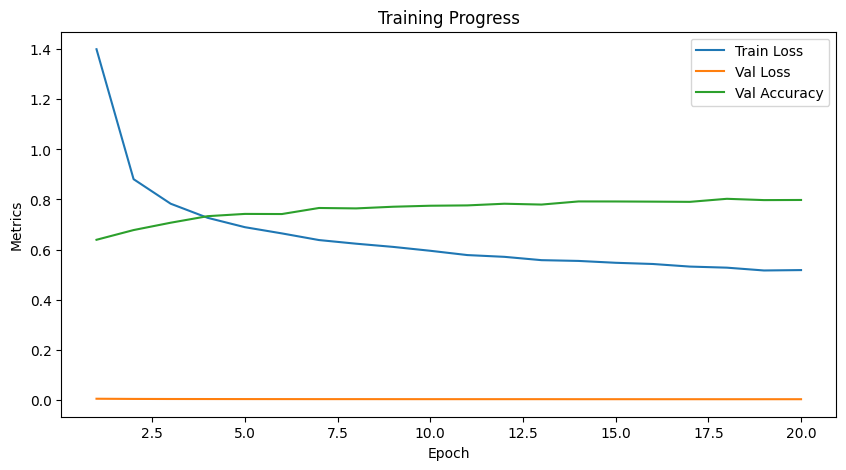

Testing [Test]: 100%|████████████████████████| 40/40 [00:01<00:00, 21.73it/s, test_acc=81.6, test_loss=0.00201]


In [5]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

model = MLP(input_size=28*28, output_size=10)
trainer = fashion_mnist_trainer(model=model, lr=0.01, batch_size=256, epoch=20, train_transforms=train_transforms, test_transforms=test_transforms)
trainer.train()
trainer.test()